In [1]:
import os
import h5py
import tqdm
import json
import torch
import pickle
import helpers
import warnings
import numpy as np 
from copy import copy
import pylab as plt
from os.path import join
from scipy import signal
from copy import deepcopy
from vms.sl import SL_sdde
from sbi.analysis import pairplot
from multiprocessing import Pool
from helpers import normalize_theta
from sbi.utils.user_input_checks import process_prior
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(2)
torch.manual_seed(2)

subfolder = "0"
path = "output"
os.makedirs(join(path, subfolder), exist_ok=True);

In [3]:
weights = np.loadtxt(join("connectivity", "weights.txt"))
tract_lenghts = np.loadtxt(join("connectivity", "tract_lengths.txt")) / 1000.0
np.fill_diagonal(weights, 0.0)
np.fill_diagonal(tract_lenghts, 0.0)

weights = weights/np.max(weights)
weights = np.abs(weights) * 2.0
assert(np.trace(weights) == 0.0)
num_nodes = weights.shape[0]
omega = 2*np.pi * 40.0 * np.ones(num_nodes)

In [4]:
parameters = {
    "G": 1000.0,                   # global coupling strength
    "a": -5.0,                     # biforcatio parameter
    "dt": 1e-4,                    # time step [s]
    'sigma_r': 1e-4,               # noise strength
    'sigma_v': 1e-4,               # noise strength
    'omega': omega,                # natural frequency [Hz]
    "noise_seed": 0,
    "velocity": 6.0,               # velocity          [m/s]

    "t_initial": 0.0,              # initial time    [s] 
    "t_transition": 2.0,           # transition time [s]
    "t_end": 10.0,                 # end time        [s]   
    "method": "euler",

    "weights": weights,            # weighted connection matrix
    "distances": tract_lenghts,    # distance matrix
    "record_step": 1,              # sampling every n step from mpr time series
    "data_path": "output",         # output directory
    "RECORD_TS": 0,                # true to store large time series in file
}


In [6]:
import json 
import torch
import sbi.utils as utils
import multiprocessing as mp
from vms.inference import Inference

np.random.seed(2)
torch.manual_seed(2)

NUM_SIMULATIONS = 20000
N_JOBS = 10

# prior_PAR_min = [800.0, 2.5]
# prior_PAR_max = [1800.0, 30.0]

prior_PAR_min = [0.0, 0.0]
prior_PAR_max = [1.0, 1.0]

fs = 1.0/(parameters["dt"]*parameters["record_step"])

prior_dist = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_PAR_min),
    high=torch.as_tensor(prior_PAR_max))

sol = Inference()
prior, _, _ = process_prior(prior_dist)
theta = prior.sample((NUM_SIMULATIONS,)) 
torch.save(theta, join(path, "theta.pt"))
torch.save(prior, join(path, "prior.pt"))

# normalize theta
theta_norm = normalize_theta(theta)
torch.save(theta_norm, join(path, subfolder, "theta_norm.pt"))
torch.save(prior, join(path, subfolder, "prior.pt"))

In [7]:
theta.shape, theta_norm.shape, theta_norm.min(axis=0), theta_norm.max(axis=0)

(torch.Size([20000, 2]),
 torch.Size([20000, 2]),
 torch.return_types.min(
 values=tensor([5.4504e-05, 5.2634e-05]),
 indices=tensor([4262, 5135])),
 torch.return_types.max(
 values=tensor([0.9999, 1.0000]),
 indices=tensor([ 8228, 18070])))

In [8]:
def simulator(params, par=None):
    
    _par = deepcopy(params)
    sol = SL_sdde(_par)
    control = {}
    if par is not None:
        par = np.array(par).astype(np.float64)
        control = {"G": par[0], "velocity": par[1]}
    data = sol.run(par=control)

    fs = 1/(parameters['dt']*parameters['record_step'])
    freq, pxx = signal.welch(data['x'], fs=fs, nperseg=data['x'].shape[1]//3)
    return data, freq, pxx*1e12

def wrapper(params, par):

    data, freq, pxx = simulator(params, par)
    
    fmin = 6.0
    fmax = 13.0

    idx = np.where((freq >= 0.0) & (freq <= 50.0))[0]
    pxx = pxx[:, idx]
    freq = freq[idx]
    pxx_avg = np.mean(pxx, axis=0)
    ind = np.argmax(pxx_avg)

    pwr = np.median(pxx, axis=0)
    ind_m = np.argmax(pwr)
    
    idx = np.logical_and(freq >= fmin, freq <= fmax).tolist()
    area_avg = np.trapz(pxx_avg[idx], freq[idx])
    area_med = np.trapz(pwr[idx], freq[idx])

    return freq[ind_m], pwr[ind_m], area_med, freq[ind], pxx_avg[ind], area_avg

def plot_ts_pxx(data, freq, pxx, ax=None, **kwargs):

    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,3.5))
        
    ax[0].plot(data['t'], data['x'].mean(axis=0), **kwargs)
    ax[0].set_xlabel("Time [s]", fontsize=14)

    ax[1].plot(freq, np.mean(pxx, axis=0), **kwargs)
    ax[1].set_xlabel("Frequency [Hz]", fontsize=14)
    ax[1].set_xlim(0, 50)
    ax[0].set_xlim(9, 10)
    for i in range(2):
        ax[i].tick_params(labelsize=14)
    plt.tight_layout()

    return ax


def batch_run(parameters, par_list):

    num_simulations = len(par_list)

    def update_bar(_):
        pbar.update()

    with Pool(processes=N_JOBS) as pool:
        with tqdm.tqdm(total=num_simulations) as pbar:
            async_results = [
                pool.apply_async(
                    wrapper, args=(parameters, par_list[i]), callback=update_bar
                )
                for i in range(num_simulations)
            ]
            data = [async_result.get() for async_result in async_results]

    return data

In [10]:
par_list = []
for i in range(theta.shape[0]):
    par = [theta[i, 0].item(), theta[i, 1].item()]
    par_list.append(par)
num_simulations = len(theta)
print(len(par_list))

20000


In [11]:
stats_vec = wrapper(parameters, par_list[0])

In [12]:
[print(f"{i:.1f}", end=" ") for i in par_list[0]]
[print(f"{i:.2f}") for i in stats_vec];

In [13]:
x = torch.as_tensor(batch_run(parameters, par_list), dtype=torch.float32)

In [14]:
torch.save(x, join(path, "data_x.pt"))
x = torch.load(join(path, "data_x.pt"))

In [15]:
x.shape

torch.Size([20000, 6])

In [16]:
data, freq, pxx = simulator(parameters, [1200.0, 27.0])

In [17]:
plot_ts_pxx(data, freq, pxx)

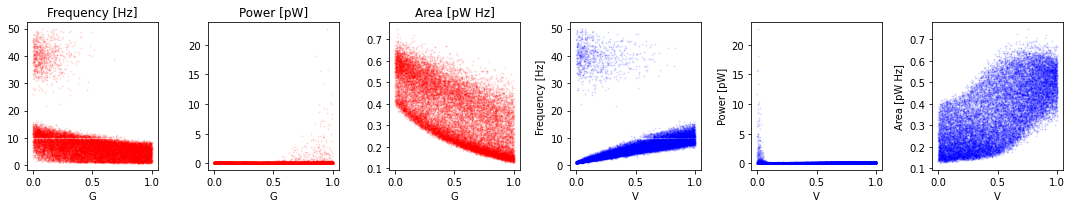

In [18]:
# MEDIAN
alpha=0.1

x_ = x.numpy()
fig, ax = plt.subplots(1, 6, figsize=(15, 3))
ax[0].plot(theta_norm[:, 0].numpy(), x_[:, 3], 'o', alpha=alpha, color='r', ms=1)
ax[1].plot(theta_norm[:, 0].numpy(), x_[:, 4], 'o', alpha=alpha, color='r', ms=1)
ax[2].plot(theta_norm[:, 0].numpy(), x_[:, 5], 'o', alpha=alpha, color='r', ms=1)
ax[3].plot(theta_norm[:, 1].numpy(), x_[:, 3], 'o', alpha=alpha, color="b", ms=1)
ax[4].plot(theta_norm[:, 1].numpy(), x_[:, 4], 'o', alpha=alpha, color="b", ms=1)
ax[5].plot(theta_norm[:, 1].numpy(), x_[:, 5], 'o', alpha=alpha, color="b", ms=1)

for i in range(3):
    ax[i].set_xlabel(r"G")
    ax[i+3].set_xlabel(r"V")

ax[0].set_title(r"Frequency [Hz]")
ax[3].set_ylabel(r"Frequency [Hz]")
ax[1].set_title(r"Power [pW]")
ax[4].set_ylabel(r"Power [pW]")
ax[2].set_title(r"Area [pW Hz]")
ax[5].set_ylabel(r"Area [pW Hz]")
plt.tight_layout()

In [19]:
x_ = torch.load(join(path, "data_x.pt"))
theta = torch.load(join(path, "theta.pt"))
print(x_.shape, theta.shape, x_[0,:])

torch.Size([20000, 6]) torch.Size([20000, 2]) tensor([5.6330, 0.0791, 0.1631, 5.6330, 0.0936, 0.2876])


In [20]:
# scaling features
x = x_.clone().detach()
x[1,:]

tensor([10.5093,  0.1182,  0.3655, 10.5093,  0.1391,  0.4992])

In [21]:
obj = Inference(parameters)

In [22]:
posterior = obj.train(num_simulations, prior, x[:, :], theta_norm[:, :], 16)

 Neural network successfully converged after 180 epochs.train Done in 0 hours 6 minutes 41.062433 seconds


In [23]:
with open(join(path, subfolder, f"posterior.pickle"), "wb") as cf:
    pickle.dump({"posterior": posterior}, cf)
posterior = pickle.load(open(join(path, subfolder, f"posterior.pickle"), "rb"))['posterior']

In [45]:
data_obs, freq_obs, pxx_obs = simulator(parameters, [1200.0, 20.0])

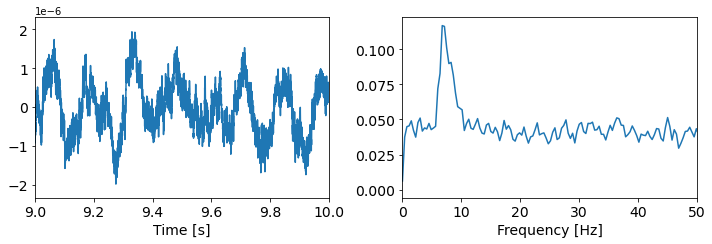

In [46]:
fig, ax = plt.subplots(1,2, figsize=(10, 3.5))
plot_ts_pxx(data_obs, freq_obs, pxx_obs, ax=ax);

In [23]:
theta_obs = [1200.0, 20.0]
# theta_obs_norm = [0., 0.]
# theta_obs_norm[0] = (theta_obs[0] - 800.0) / 1000.0
# theta_obs_norm[1] = (theta_obs[1] - 2.5) / 27.5
theta_obs_norm = normalize_theta(torch.tensor(theta_obs).reshape(1,-1)).numpy().squeeze().tolist()
print(theta_obs_norm)

x_obs = wrapper(parameters, theta_obs)
x_obs = torch.tensor(x_obs, dtype=torch.float32).reshape(1,-1)

[0.4000000059604645, 0.6363636255264282]


In [24]:
# torch.save(x_obs, join(data_path, "x_obs.pt"))
x_obs = torch.load(join(path, "x_obs.pt"))
x_obs.numpy()

array([[7.884659  , 0.08313757, 0.26352486, 7.884659  , 0.09750651,
        0.40384257]], dtype=float32)

In [25]:
samples = obj.sample_posterior(x_obs[:, :], 10_000, posterior)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 350114.69it/s]


In [26]:
torch.save(samples, join(path, subfolder, "samples.pt"))
samples = torch.load(join(path, "samples.pt"))

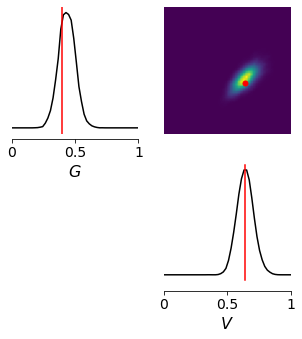

In [28]:
limits = [[i, j] for i, j in zip(prior_PAR_min, prior_PAR_max)]

fig, ax = pairplot(
    samples,
    points=[theta_obs_norm],
    figsize=(5, 5),
    limits=limits,
    labels=["G", "V"],
    upper='kde',
    diag='kde',
    # title=f"n = {len(theta)}",
    points_colors="r",
    samples_colors="k",
    points_offdiag={'markersize': 10})

ax[0,0].tick_params(labelsize=14)
ax[1,1].tick_params(labelsize=14)
ax[0,0].margins(y=0)
ax[0,0].set_xlabel(r"$G$", fontsize=16)
ax[1,1].set_xlabel(r"$V$", fontsize=16)
fig.savefig(join(path, "triangleplot.png"), dpi=600, bbox_inches='tight')
fig.savefig(join(path, "triangleplot.svg"), dpi=600, bbox_inches='tight')



In [29]:
from vms.utility import posterior_peaks
theta_peak_norm = posterior_peaks(samples, labels=["G", "V"])
print(theta_peak_norm)
# [1123.559136838329, 19.19439206804548]

[0.42299634765605537, 0.6436310519977492]


In [30]:
from helpers import denormalize_theta

theta_peak_norm = torch.tensor(theta_peak_norm, dtype=torch.float32).reshape(1,-1)
theta_peak = denormalize_theta(theta_peak_norm)
theta_peak = theta_peak.numpy().squeeze().tolist()
theta_peak

[1222.996337890625, 20.199853897094727]

In [31]:
data_fit, freq_fit, pxx_fit = simulator(parameters, theta_peak)

In [32]:
def smoothing(x, y, window_size=5, order=3):
    from scipy.signal import savgol_filter
    return savgol_filter(y, window_size, order)


def plot_ts_pxx_(data1, data2, freq1, freq2,
                 pxx1, pxx2, ax=None, alpha=0.7,
                 fontsize=16):

    data1['x'] = data1['x']/np.max(data1['x'])
    data2['x'] = data2['x']/np.max(data2['x'])

    ax[0].plot(data1['t'], data1['x'].mean(
        axis=0), lw=1, color='r', alpha=alpha, label="Obs")
    ax[0].plot(data2['t'], 0.2 + data2['x'].mean(axis=0),
               lw=1, color='b', alpha=alpha, label="Fit")

    y1 = smoothing(freq1, pxx1.mean(axis=0), window_size=11, order=3)
    y2 = smoothing(freq2, pxx2.mean(axis=0), window_size=11, order=3)
    ax[1].plot(freq1, y1, lw=2, color='r', alpha=alpha, label="Obs")
    ax[1].plot(freq2, y2, lw=2, color='b', alpha=alpha, label="Fit")

    ax[0].set_xlabel("Time [s]", fontsize=fontsize)
    ax[1].set_xlabel("Frequency [Hz]", fontsize=fontsize)
    ax[0].set_ylabel("Amplitude [a.u]", fontsize=fontsize)
    ax[1].set_ylabel("PSD [a.u]", fontsize=fontsize)
    ax[1].set_xlim(0, 50)
    ax[0].set_xlim(9, 10)
    ax[0].set_yticks([])
    for i in range(2):
        ax[i].tick_params(labelsize=14)
    ax[1].legend(fontsize=14, loc='upper right')
    plt.tight_layout()


In [68]:
# store to pickle
# data_fit_psd = {"data_obs": data_obs, "data_fit": data_fit,
#                 "freq_obs": freq_obs, "freq_fit":freq_fit,
#                 "pxx_obs": pxx_obs, "pxx_fit": pxx_fit}
# with open(join(data_path, f"data_fit_psd.pickle"), "wb") as cf:
#     pickle.dump({"data": data_fit_psd}, cf)


In [31]:
# load from pickle
data_fit_psd = pickle.load(open(join(path, f"data_fit_psd.pickle"), "rb"))['data']
data_obs = data_fit_psd['data_obs']
data_fit = data_fit_psd['data_fit']
freq_obs = data_fit_psd['freq_obs']
freq_fit = data_fit_psd['freq_fit']
pxx_obs = data_fit_psd['pxx_obs']
pxx_fit = data_fit_psd['pxx_fit']


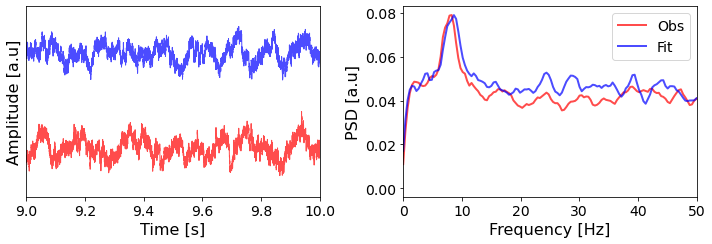

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
plot_ts_pxx_(data_obs, data_fit,
            freq_obs, freq_fit,
            pxx_obs, pxx_fit, 
            ax=ax)
plt.savefig(join(path, "fit_psd.png"), dpi=600)
plt.savefig(join(path, "fit_psd.svg"), dpi=600)


In [33]:
type(theta_peak), type(theta_peak[0])

(list, numpy.float64)

In [33]:
from sbi.analysis import ActiveSubspace

In [34]:
posterior_active = posterior.set_default_x(x_obs[:, :])
sensitivity = ActiveSubspace(posterior_active)

e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 150112.88it/s]


In [35]:
print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)

Eigenvalues: 
 tensor([1.1771e-05, 6.0472e-05]) 

Eigenvectors: 
 tensor([[ 0.7171,  0.6970],
        [ 0.6970, -0.7171]])


In [36]:
import seaborn as sns
# sns.set_theme(style="darkgrid")
def plot_bar(ax, labels, y, ylabel=None):

    x = np.arange(len(labels))
    sns.barplot(x=x, y=y, palette="Reds_d")
    # ax.legend(loc='best', frameon=False)
    ax.set_xticks(x, labels)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=18)
    ax.grid(False)
    sns.despine(bottom = False, left = False)

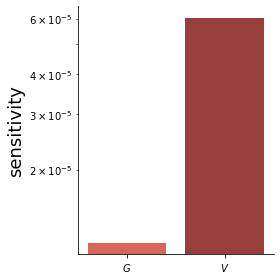

In [37]:
fig, ax = plt.subplots(1, figsize=(4, 4))
plot_bar(ax, [r"$G$", r"$V$"], e_vals.numpy().squeeze(), ylabel="sensitivity")
ax.set_yscale('log')
plt.tight_layout()
plt.savefig(join(path, "sensitivity.png"), dpi=600);

In [40]:
# store in json file
results = {"G": theta_peak[0], "V": theta_peak[1], "sensitivity": (e_vals.numpy().squeeze()).tolist()}
with open(join(path, subfolder, "results.json"), "w") as cf:
    json.dump(results, cf)

In [41]:
x.shape, theta_norm.shape, x_obs.shape

(torch.Size([20000, 6]), torch.Size([20000, 2]), torch.Size([1, 6]))

In [43]:
subfolder = "0/num_sim"
if not os.path.exists(join(path, subfolder)):
    os.makedirs(join(path, subfolder))


n_sim = [100, 1000, 20000]

for i in range(len(n_sim)):

    num = n_sim[i]
    sol = Inference(parameters)
    posterior = obj.train(n_sim[i], prior, x[:n_sim[i], :], theta_norm[:n_sim[i], :], 16)

    with open(join(path, subfolder, f"posterior_{n_sim[i]}.pickle"), "wb") as cf:
        pickle.dump({"posterior": posterior}, cf)
    # posterior = pickle.load(open(join(data_path, subfolder, f"posterior_{n_sim[i]}.pickle"), "rb"))['posterior']
    
    samples = obj.sample_posterior(x_obs[:, :], 10_000, posterior)
    torch.save(samples, join(path, subfolder, f"samples_{n_sim[i]}.pt"))
    # samples = torch.load(join(data_path, subfolder, f"samples_{n_sim[i]}.pt"))



 Neural network successfully converged after 152 epochs.train Done in 0 hours 0 minutes 01.537802 seconds


Drawing 10000 posterior samples: 10202it [00:00, 431527.73it/s]           


 Neural network successfully converged after 117 epochs.train Done in 0 hours 0 minutes 12.088728 seconds


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 494040.38it/s]


 Neural network successfully converged after 129 epochs.train Done in 0 hours 4 minutes 45.143315 seconds


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 477477.32it/s]


In [40]:
samples_100 = torch.load(join(path, subfolder, f"samples_100.pt"))
samples_100.shape

torch.Size([10000, 2])